In [8]:
library(randomizr)
library(ri2)
library(dplyr)

## Part I: Fisherian randomization inference

In [9]:
df = read.csv('cai_training.csv')

In [10]:
dim(df);colnames(df)

[1] 4902   25

[1] "id"                    "region"                "village"              
 [4] "age"                   "agpop"                 "rice_inc"             
 [7] "ricearea_2010"         "general_trust"         "educ"                 
[10] "educ_good"             "male"                  "disaster_loss"        
[13] "disaster_yes"          "risk_averse"           "literacy"             
[16] "age_missing"           "agpop_missing"         "rice_inc_missing"     
[19] "ricearea_2010_missing" "disaster_loss_missing" "educ_missing"         
[22] "intensive"             "takeup_survey"         "block"                
[25] "prob"

In [11]:
head(df)

id,region,village,age,agpop,rice_inc,ricearea_2010,general_trust,educ,educ_good,⋯,age_missing,agpop_missing,rice_inc_missing,ricearea_2010_missing,disaster_loss_missing,educ_missing,intensive,takeup_survey,block,prob
1,1,12,76,5,40,5.00,1,1,0,⋯,0,0,0,0,1,0,0,1,5,0.25
1,1,12,54,4,100,10.00,0,0,0,⋯,0,0,0,0,0,0,1,1,1,0.50
1,1,12,67,2,60,10.00,1,2,1,⋯,0,0,0,0,1,0,1,1,2,0.25
1,1,12,74,2,30,0.74,1,1,0,⋯,0,0,0,0,0,0,0,1,253,0.25
1,1,12,60,6,50,11.00,0,1,0,⋯,0,0,0,0,0,0,0,1,414,0.25
1,1,12,56,6,90,13.00,0,1,0,⋯,0,0,0,0,1,0,1,0,277,0.50


In [12]:
# store the probability of receiving the treatment by block
block_prob = df %>% select(block,prob) %>% group_by(block) %>% slice(1)

In [13]:
# declare the randonmization procedure
ra = declare_ra(N = nrow(df),
                blocks = df$block,
                block_prob = block_prob$prob)

In [14]:
ra

Random assignment procedure: Block random assignment 
Number of units: 4902 
Number of blocks: 686
Number of treatment arms: 2 
The possible treatment categories are 0 and 1.
The number of possible random assignments is approximately infinite. 
The probabilities of assignment are NOT constant across units. Your analysis strategy must account for differential probabilities of assignment, typically by employing inverse probability weights.

In [15]:
ri = conduct_ri(takeup_survey ~ intensive, # using regression to analyze the results
declaration = ra,
assignment = "intensive",
outcome = 'takeup_survey',
sharp_hypothesis = 0,
IPW = TRUE,
IPW_weights = ifelse(intensive==1,1/prob,1/(1-prob)), # because treatment probability varies across blocks, we use inverse probability weighting
sims = 1000, 
data = df)

In [17]:
summary(ri)

term,estimate,two_tailed_p_value
intensive,0.1685915,0


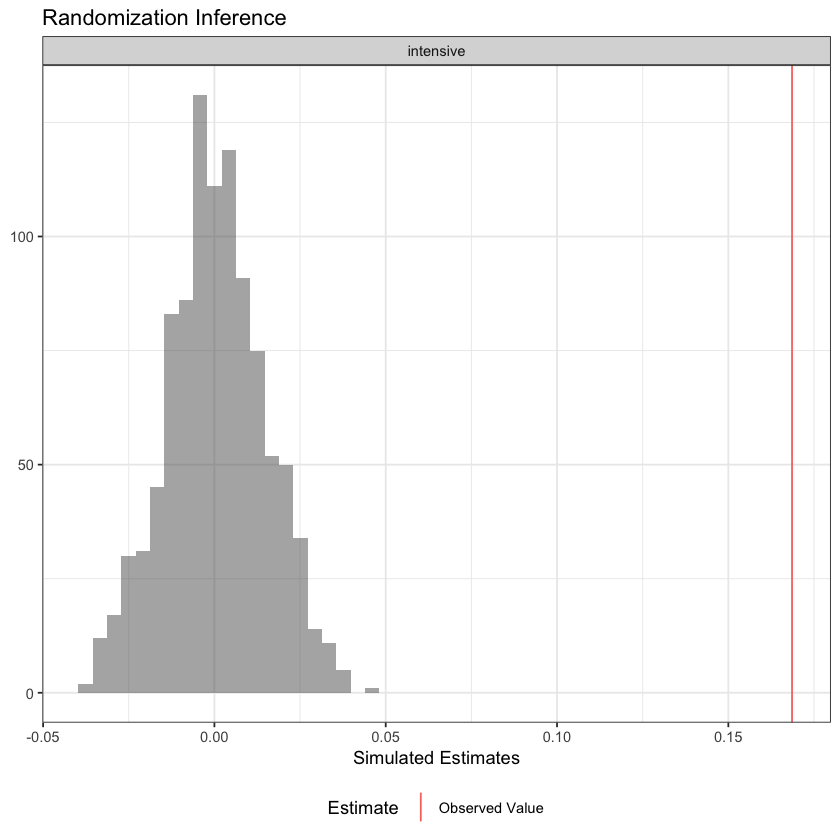

In [18]:
plot(ri)

In [29]:
ra_complete = declare_ra(N = nrow(df),
                        m = sum(df$intensive))

In [30]:
ra_complete

Random assignment procedure: Complete random assignment 
Number of units: 4902 
Number of treatment arms: 2 
The possible treatment categories are 0 and 1.
The number of possible random assignments is approximately infinite. 
The probabilities of assignment are constant across units: 
   prob_0    prob_1 
0.6003672 0.3996328 

In [31]:
ri_complete = conduct_ri(takeup_survey ~ intensive,
declaration = ra_complete,
assignment = "intensive",
outcome = 'takeup_survey',
sharp_hypothesis = 0,
sims = 1000, 
data = df)

In [32]:
summary(ri_complete)

term,estimate,two_tailed_p_value
intensive,0.215977,0


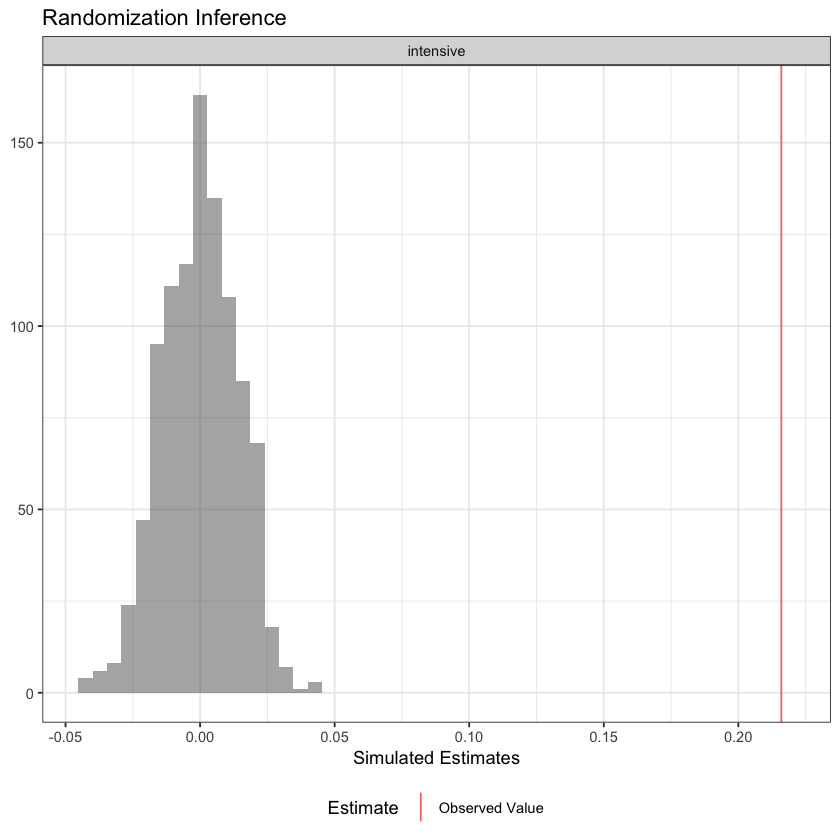

In [33]:
plot(ri_complete)

## Part II: Counterfactual policy evaluation & learning

In [19]:
# calculate the profit for each individual 
df$profit = 100*df$takeup_survey - 15*df$intensive

We use Hajek estimator to calculate the average outcome under counterfactual policies:

$$\hat{\mu}(\pi) = \frac{1}{\sum_i{w_i}} \sum_i Y_iw_i$$ 
$$w_i = \frac{\pi(Z_i|X_i)}{\pi_0(Z_i|X_i)}$$

where $Z_i$ is the treatment assignment, $X_i$ is the covariates and $Y_i$ is the outcome (here we will use the revenue). $\pi_0$ is the policy that's used for treatment assignment in the experiment, $\pi$ is the counterfactual policy that we want to evaluate.

### (1) the policy that treats everybody

Under this policy we have:

$$\pi(Z_i|X_i) = 
\begin{array}{cc}
  \{ & 
    \begin{array}{cc}
      1 & Z_i=1 \\
      0 & Z_i=0
    \end{array}
\end{array}
$$

In [20]:
# the weights for policy (1)
w1 = with(df, 
          ifelse(intensive==1,1,0)/ifelse(intensive==1,prob,1-prob)) 

In [21]:
# calculate the average profit under policy (1)
mu1 = weighted.mean(df$profit,w1)
mu1

# total profit
mu1 * nrow(df)

[1] 60.93954

[1] 298725.6

### (2) the policy that treats nobody

Under this policy we have:

$$\pi(Z_i|X_i) = 
\begin{array}{cc}
  \{ & 
    \begin{array}{cc}
      0 & Z_i=1 \\
      1 & Z_i=0
    \end{array}
\end{array}
$$

In [22]:
# the weights for policy (2)
w2 = with(df, 
          ifelse(intensive==1,0,1)/ifelse(intensive==1,prob,1-prob)) 

In [23]:
# calculate the average profit under policy (2)
mu2 = weighted.mean(df$profit,w2)
mu2

# total profit
mu2 * nrow(df)

[1] 59.0804

[1] 289612.1

### (3) the policy that treats 20% at random

Under this policy we have:

$$\pi(Z_i|X_i) = 
\begin{array}{cc}
  \{ & 
    \begin{array}{cc}
      0.2 & Z_i=1 \\
      0.8 & Z_i=0
    \end{array}
\end{array}
$$

In [24]:
# the weights for policy (3)
w3 = with(df, 
          ifelse(intensive==1,0.2,0.8)/ifelse(intensive==1,prob,1-prob)) 

In [25]:
# calculate the average profit under policy (3)
mu3 = weighted.mean(df$profit,w3)
mu3

# total profit
mu3 * nrow(df)

[1] 59.45194

[1] 291433.4

### (4) the policy that only treats risk aversion score (risk_averse) greater than 0.5:

Under this policy we have:


$$\pi(Z_i|X_i) = 
\begin{array}{cc}
  \{ & 
    \begin{array}{cc}
        1 & Z_i=1 \ \  \& \ \  \text{risk_averse > 0.5} \ \ \text{or} \\
         & Z_i=0 \ \  \& \ \  \text{risk_averse <= 0.5}\\
        0 & Z_i=1 \ \  \& \ \  \text{risk_averse <= 0.5} \ \ \text{or}\\
         & Z_i=0 \ \  \& \ \  \text{risk_averse > 0.5}\\
    \end{array}
\end{array}
$$

In [26]:
# the weights for policy (4)
w4 = with(df, 
          ifelse((intensive==1 & risk_averse > 0.5)|(intensive==0 & risk_averse <= 0.5) ,1,0)/ifelse(intensive==1,prob,1-prob)) 

In [27]:
# calculate the average revenue under policy (4)
mu4 = weighted.mean(df$profit,w4)
mu4

# total revenue
mu4 * nrow(df)

[1] 58.53446

[1] 286935.9

### (5) optimal policy

<br>

The optimal policy only treats people for whom there's a positive treatment effect (net of the cost of treatment). There are different ways of identifying the conditional average treatment effect (CATE) $\tau(X_i)$, this is an open-ended question and we can take three approaches: 

#### (1) only use an outcome model 

We can regress $Y_i$ on treatment $W_i$ and covariates $X_i$, estimate $\hat{Y}_i(1)$, $\hat{Y}_i(0)$, then $\hat{\tau}(X_i)= \hat{Y}_i(1) - \hat{Y}_i(0)$. 

#### (2) only use a propensity model

In this case we make no assumptions on the outcome process, and in an experiment we know the true propensity model. 

We can construct the transformed outcome $Y_i^* = Y_i(1)\frac{W_i}{e(X_i)} + Y_i(0)\frac{1-W_i}{1-e(X_i)}$ then $\hat{\tau}(X_i)= E(Y_i^*|X_i)$.

#### (3) use a doubly robust score model

We can combine the two approaches in (1) and (2) by constructing doubly robutst scores as in the lecture note.

<br>

Once we have $\hat{\tau}(X_i)$, we can target $\forall i: \hat{\tau}(X_i) - c > 0$, where $c$ is the cost of intervention. 

We can also frame the decision as a weighted classification problem in which the sign of $\hat{\tau}(X_i)$ is the class label and the magnitude $|\hat{\tau}(X_i)|$ is the weight. One benefit of doing this is that we can use two different sets of covariates for estimating $\hat{\tau}(X_i)$ and training the classifier. One reason we might want to do this is that it might not be allowed to condition the targeting policy on certain covariates for fairness reasons, but we can still use those covariates to construct $\hat{\tau}(X_i)$.